<a href="https://colab.research.google.com/github/iliya1984/DevML/blob/main/yale_face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from PIL import Image
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from google.colab import drive

import zipfile
import os
import random
from sklearn.metrics import accuracy_score

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! ls

content  drive	sample_data


In [4]:
zip_file_path = '/content/drive/MyDrive/Workspace/Computer Vision/datasets/yalefaces.zip'
extract_path = './content/datasets/yalefaces'
models_path = './content/models'
model_yml_path = models_path + '/lbph_classifier.yml'

In [5]:
zip_object = zipfile.ZipFile(file=zip_file_path, mode = 'r')
zip_object.extractall(extract_path)
zip_object.close()

In [6]:
#print(os.listdir(extract_path))

In [7]:
class FaceImages:
  def __init__(self):
    self.images = []

  def get_npimages(self):
    images = []
    for image in self.images:
      np_image = image.image
      images.append(np_image)
    return images

  def get_ids(self):
    ids = []
    for image in self.images:
      id = image.id
      ids.append(id)

    return np.array(ids)

class FaceImage:
  def __init__(self, id, image):
    self.id = id
    self.image = image
    self.prediction = None

def get_image_paths():
  image_paths = os.listdir(extract_path)
  invalid_paths = []
  for path in image_paths:
    if not ("subject" in path):
      print(f'Invalid path "{path}"')
      invalid_paths.append(path)

  for path in invalid_paths:
    image_paths.remove(path)
    print(f'Removed path "{path}"')

  return image_paths

#paths = [os.path.join(extract_path, f) for f in os.listdir(extract_path)]
#print(paths)

def get_image_data():
  image_paths = get_image_paths()
  paths = [os.path.join(extract_path, f) for f in image_paths]
  #print(paths)

  images = FaceImages()
  for path in paths:
    #print(path)
    image = Image.open(path).convert('L')
    #print(type(image))
    image_np = np.array(image, 'uint8')
    #print(type(image_np))
    id = int(os.path.split(path)[1].split('.')[0].replace('subject', ''))
    #print(id)
    images.images.append(FaceImage(id, image_np))

  return images

In [8]:
faces = get_image_data()
random.shuffle(faces.images)

Invalid path "data"
Invalid path "Readme.txt"
Removed path "data"
Removed path "Readme.txt"


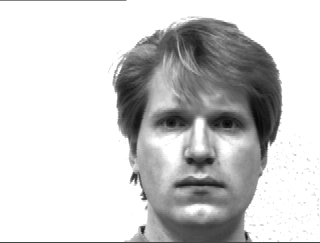

In [9]:
cv2_imshow(faces.get_npimages()[0])

In [10]:
dataset_size = len(faces.images)
train_set = FaceImages()
test_set = FaceImages()

split_ratio = 0.75
split_threshold = int(split_ratio * dataset_size)

index = 0;
for face in faces.images:
  if index < split_threshold:
    train_set.images.append(face)
  else:
    test_set.images.append(face)

  index = index + 1

print(f'Splited faces dataset to a train set of the size {len(train_set.images)} and a test set of the size {len(test_set.images)}')


Splited faces dataset to a train set of the size 123 and a test set of the size 42


In [11]:
len(train_set.get_ids())

123

In [ ]:
lbph_classifier = cv2.face.LBPHFaceRecognizer_create(radius = 4, neighbors=14, grid_x = 9, grid_y = 9)
lbph_classifier.train(train_set.get_npimages(), train_set.get_ids())
lbph_classifier.write(model_yml_path)

In [13]:
lbph_face_classifier = cv2.face.LBPHFaceRecognizer_create()
lbph_face_classifier.read(model_yml_path)

In [14]:
test_image = test_set.images[0]
prediction = lbph_face_classifier.predict(test_image.image)
prediction

(2, 76.27042987200709)

In [15]:
test_image.id

2

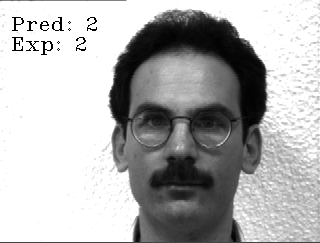

In [16]:
cv2.putText(test_image.image, 'Pred: ' + str(prediction[0]), (10, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,255,0))
cv2.putText(test_image.image, 'Exp: ' + str(test_image.id), (10, 50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,255,0))
cv2_imshow(test_image.image)

In [17]:
predictions = []
labels = []

for test_image in test_set.images:
  prediction, _ = lbph_face_classifier.predict(test_image.image)
  predictions.append(prediction)
  labels.append(test_image.id)

predictions = np.array(predictions)
labels = np.array(labels)

In [18]:
accuracy_score(labels, predictions)

0.7857142857142857